In [1]:
# Importing Required Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
# Reading in the dataset & getting its info
df = pd.read_csv('prepared_data.csv',index_col='Date',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2016-10-01 to 2019-09-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Vol       72 non-null     float64
 1   Category  72 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [3]:
# Segregating the dataset for buiscuits and Chocolate
bis = df.loc[df['Category'] == 'BISCUIT']
#choc = df.loc[df['Category'] != 'BISCUIT']

In [4]:
# Importing keras from tensorflow
import tensorflow as tf
from tensorflow import keras

###  As we observed in the last notebook involving MLPs dealing with bis_log series, the bis_log_diff series is nearly stationary,  with past 5 lags being statistically significant in explaining the present value we would again have past 5 lags as explanatory variables.

In [5]:
# Converting the biscuit volume series into pandas series
bis_s = (bis['Vol']).copy()

In [6]:
# Taking log of the biscuit volume series to reduce variance
bis_log = np.log10(bis_s)

In [7]:
# Taking the difference = 1 of the log series & removing nan values
bis_log_diff = (bis_log.diff(1)).dropna()

In [8]:
# Function to transform series into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    ''' Transform a time series to a training and the test set'''
    df = pd.DataFrame(data)
    cols = list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
# put it all together
    agg = pd.concat(cols, axis=1)
# drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.iloc[:,:-n_out] , agg.iloc[:,-n_out:]

In [9]:
# Converting bis_log_diff series to the X_train & y_train with lag 5 values as features
X, y = series_to_supervised(bis_log_diff, n_in=5, n_out=1 )

In [10]:
# Renaming the columns of the X_train
X.columns = ['Lag_5', 'Lag_4', 'Lag_3', 'Lag_2', 'Lag_1']

In [11]:
X

,Lag_5,Lag_4,Lag_3,Lag_2,Lag_1
Date,,,,,
2017-04-01,-0.146061,-0.001623,0.101295,0.050263,0.014381
2017-05-01,-0.001623,0.101295,0.050263,0.014381,-0.084196
2017-06-01,0.101295,0.050263,0.014381,-0.084196,0.068877
2017-07-01,0.050263,0.014381,-0.084196,0.068877,-0.086267
2017-08-01,0.014381,-0.084196,0.068877,-0.086267,0.150211
2017-09-01,-0.084196,0.068877,-0.086267,0.150211,-0.001160
2017-10-01,0.068877,-0.086267,0.150211,-0.001160,0.047680
2017-11-01,-0.086267,0.150211,-0.001160,0.047680,-0.133896
2017-12-01,0.150211,-0.001160,0.047680,-0.133896,0.093957


In [12]:
len(X)

30

In [13]:
X.shape

(30, 5)

### In keeping with the earlier analysis, lets keep 6 observations in the test set, 4 in the validation & 20 in the training set.

In [14]:
# splitting the observations into training & test set
X_train, X_test = X.iloc[:24], X.iloc[24:]
y_train, y_test = y.iloc[:24], y.iloc[24:]

In [15]:
# splitting the training set  into training & validation set
X_train, X_val = X_train.iloc[:20], X_train.iloc[20:]
y_train, y_val = y_train.iloc[:20], y_train.iloc[20:]

In [16]:
# Reshaping the training, validation & test set features for LSTMs
X_train = X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.values.reshape((X_val.shape[0],X_val.shape[1],1))
X_test = X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))                

In [17]:
X_train.shape, X_val.shape, X_test.shape

((20, 5, 1), (4, 5, 1), (6, 5, 1))

In [18]:
X_train

array([[[-0.14606126],
        [-0.00162291],
        [ 0.10129452],
        [ 0.05026337],
        [ 0.01438056]],

       [[-0.00162291],
        [ 0.10129452],
        [ 0.05026337],
        [ 0.01438056],
        [-0.08419613]],

       [[ 0.10129452],
        [ 0.05026337],
        [ 0.01438056],
        [-0.08419613],
        [ 0.06887665]],

       [[ 0.05026337],
        [ 0.01438056],
        [-0.08419613],
        [ 0.06887665],
        [-0.08626747]],

       [[ 0.01438056],
        [-0.08419613],
        [ 0.06887665],
        [-0.08626747],
        [ 0.15021101]],

       [[-0.08419613],
        [ 0.06887665],
        [-0.08626747],
        [ 0.15021101],
        [-0.00116032]],

       [[ 0.06887665],
        [-0.08626747],
        [ 0.15021101],
        [-0.00116032],
        [ 0.04768004]],

       [[-0.08626747],
        [ 0.15021101],
        [-0.00116032],
        [ 0.04768004],
        [-0.13389602]],

       [[ 0.15021101],
        [-0.00116032],
        [ 0.047680

In [19]:
X_train.shape[1:]

(5, 1)

In [20]:
# Importing hyperparameter tuning tool Optuna
import optuna

In [21]:
# Importing relevant packages
from sklearn.metrics import mean_squared_error
from math import sqrt

### Tuning hyper-parameters of the LSTM Neural Net using Optuna

In [35]:
# defining the objective function
def objective_wrappper_keras_LSTM(X_tr, y_tr, X_val, y_val):
    '''
    Optimizes Keras neural net(with equal no. of neurons in each layer) best parameters 
    on the given training set: X_tr, y_tr using validation set: X_val,y_val 
    
    '''
    def objective(trial):
        # Tuning the learning rate
        s = trial.suggest_int('step',2,5)
        def exponential_decay_fn(epoch): # 
            return 0.01 * 0.1**(epoch /s )     
        
        # Building model & searching for the best no. of neural units per layer.
        no_units = trial.suggest_int('no._units',100,500)# No. of Neurons in each layer
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=X_tr.shape[1:]))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LSTM(units=no_units))
        model.add(keras.layers.Dense(units=no_units,activation='selu',
                                     kernel_initializer='lecun_normal'))
        model.add(keras.layers.Dense(units=1))
    
            
        # Compiling the model
        model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999)
                      ,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
        # Defining the Callbacks
        checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5',save_best_only=True) # 1st Callback
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True) # 2nd Callback, Stop if validation score doen't improve for
        # 30 epochs        
        lr_scheduler_cb = keras.callbacks.LearningRateScheduler(exponential_decay_fn)# 3rd Callback
        
        #Fitting the model
        model.fit(X_tr, y_tr, epochs=200, validation_data=(X_val,y_val), batch_size=1,
             callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb])
    
        # Loading the best model 
        model_best = keras.models.load_model('best_model.h5')
    
        # Computing the roc_auc_score for the validation set
        error = sqrt(mean_squared_error(y_val, model_best.predict(X_val)))
        global best_error
        # Updating best_error score
        if error < best_error:
            best_error = error
            model_best.save('Best_model_LSTM_bis.h5')
        
        return error
    
    return objective

In [36]:
# Defining the evaluation function for study's best parameters
def study_func(X_tr, y_tr, X_v, y_v, obj_func, n_trials=200):
    ''' Computes the best hyper parameters of the Neural net using the Training set(X_tr,y_tr) & Validation set
    (X_v,y_v) & returns Optuna's study's best score & clasifier parameters'''
    
    study = optuna.create_study(direction='minimize')
    study.optimize(obj_func(X_tr, y_tr, X_v, y_v), n_trials)
    best_score = study.best_value
    best_params = study.best_params
    return (best_score, best_params)

In [37]:
# Extracting the best model parameters and best study score
best_error = np.inf
best_study_score, best_study_params = study_func(X_train, y_train, X_val, y_val, objective_wrappper_keras_LSTM)
                                                

[I 2021-02-28 17:06:51,637] A new study created in memory with name: no-name-8776d7c8-d3de-400e-aedd-35bdaa8944e2


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.9773 - root_mean_squared_error: 0.9886 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1164
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:07:12,421] Trial 0 finished with value: 0.09357955858486622 and parameters: {'step': 5, 'no._units': 319}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 121ms/sample - loss: 0.5036 - root_mean_squared_error: 0.7096 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 3/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 4/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 5/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0039 - r

[I 2021-02-28 17:07:33,812] Trial 1 finished with value: 0.09606172616994355 and parameters: {'step': 4, 'no._units': 285}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 122ms/sample - loss: 2.0205 - root_mean_squared_error: 1.4214 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 3/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1107
Epoch 4/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 6/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:07:59,008] Trial 2 finished with value: 0.10102454535738027 and parameters: {'step': 4, 'no._units': 417}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 107ms/sample - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 2/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 4/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0041 - root_m

Epoch 48/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 49/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 50/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 51/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 52/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016


[I 2021-02-28 17:08:08,912] Trial 3 finished with value: 0.09630036902026785 and parameters: {'step': 3, 'no._units': 101}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1231
Epoch 2/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0711 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 4/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 5/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 6/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0043 - root_m

Epoch 48/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 49/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 50/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 51/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1046


[I 2021-02-28 17:08:19,312] Trial 4 finished with value: 0.0970119495693742 and parameters: {'step': 4, 'no._units': 115}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 4.8313 - root_mean_squared_error: 2.1980 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 5/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 6/200
20/20 [==============================] - 0s 25ms/sample - loss: 0.0049 - r

[I 2021-02-28 17:08:39,620] Trial 5 finished with value: 0.11429865411157457 and parameters: {'step': 2, 'no._units': 455}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 25.3665 - root_mean_squared_error: 5.0365 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 2/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 3/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 6/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0066 - 

[I 2021-02-28 17:09:03,017] Trial 6 finished with value: 0.1145399562983167 and parameters: {'step': 2, 'no._units': 493}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 117ms/sample - loss: 1.0305 - root_mean_squared_error: 1.0151 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - r

[I 2021-02-28 17:09:20,609] Trial 7 finished with value: 0.10292006677136031 and parameters: {'step': 4, 'no._units': 324}. Best is trial 0 with value: 0.09357955858486622.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 125ms/sample - loss: 1.7081 - root_mean_squared_error: 1.3069 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 2/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 5/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0060 - r

[I 2021-02-28 17:09:45,487] Trial 8 finished with value: 0.06212481745918988 and parameters: {'step': 3, 'no._units': 405}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 107ms/sample - loss: 0.1039 - root_mean_squared_error: 0.3224 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 4/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 6/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0045 - root_m

Epoch 48/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 49/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 50/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076


[I 2021-02-28 17:09:55,819] Trial 9 finished with value: 0.09982169516070478 and parameters: {'step': 4, 'no._units': 193}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 122ms/sample - loss: 3.0847 - root_mean_squared_error: 1.7563 - val_loss: 0.1361 - val_root_mean_squared_error: 0.3689
Epoch 2/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0638 - root_mean_squared_error: 0.2526 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 3/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 4/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 5/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - r

[I 2021-02-28 17:10:13,732] Trial 10 finished with value: 0.10873329197039222 and parameters: {'step': 3, 'no._units': 395}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 114ms/sample - loss: 0.3588 - root_mean_squared_error: 0.5990 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1346
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1191
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - r

[I 2021-02-28 17:10:27,515] Trial 11 finished with value: 0.11717039416082564 and parameters: {'step': 5, 'no._units': 323}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 107ms/sample - loss: 0.0882 - root_mean_squared_error: 0.2969 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 5/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0643 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0039 - root_m

[I 2021-02-28 17:10:38,016] Trial 12 finished with value: 0.10263349010112943 and parameters: {'step': 5, 'no._units': 244}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 117ms/sample - loss: 0.7756 - root_mean_squared_error: 0.8807 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0028 - r

[I 2021-02-28 17:10:52,590] Trial 13 finished with value: 0.10463837510635134 and parameters: {'step': 3, 'no._units': 358}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 2.6718 - root_mean_squared_error: 1.6346 - val_loss: 0.1781 - val_root_mean_squared_error: 0.4220
Epoch 2/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1233
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:11:10,122] Trial 14 finished with value: 0.11308818500443016 and parameters: {'step': 5, 'no._units': 393}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 108ms/sample - loss: 0.2865 - root_mean_squared_error: 0.5353 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1116
Epoch 4/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0044 - root_m

Epoch 48/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 49/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 50/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 51/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 52/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 53/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0

[I 2021-02-28 17:11:21,498] Trial 15 finished with value: 0.09570950664895284 and parameters: {'step': 3, 'no._units': 238}. Best is trial 8 with value: 0.06212481745918988.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 132ms/sample - loss: 5.0989 - root_mean_squared_error: 2.2581 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1295
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0305 - root_mean_squared_error: 0.1746 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 6/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0091 - r

[I 2021-02-28 17:11:59,186] Trial 16 finished with value: 0.030316751571313257 and parameters: {'step': 2, 'no._units': 471}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 8.6999 - root_mean_squared_error: 2.9496 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0094 - root_mean_squared_error: 0.0967 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 3/200
20/20 [==============================] - 1s 30ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1093
Epoch 4/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 5/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0050 - r

[I 2021-02-28 17:12:23,380] Trial 17 finished with value: 0.10932513904457099 and parameters: {'step': 2, 'no._units': 497}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 125ms/sample - loss: 1.6060 - root_mean_squared_error: 1.2673 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0050 - r

[I 2021-02-28 17:12:45,608] Trial 18 finished with value: 0.11102474105823318 and parameters: {'step': 2, 'no._units': 448}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 2.2847 - root_mean_squared_error: 1.5115 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1317
Epoch 2/200
20/20 [==============================] - 0s 25ms/sample - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1336
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:13:18,530] Trial 19 finished with value: 0.0771343860402834 and parameters: {'step': 3, 'no._units': 455}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 9s 434ms/sample - loss: 7.0562 - root_mean_squared_error: 2.6563 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1306
Epoch 2/200
20/20 [==============================] - 1s 30ms/sample - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/200
20/20 [==============================] - 1s 31ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 4/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 5/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:13:56,093] Trial 20 finished with value: 0.10371088904936991 and parameters: {'step': 2, 'no._units': 498}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 4.0742 - root_mean_squared_error: 2.0185 - val_loss: 0.0800 - val_root_mean_squared_error: 0.2829
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 4/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 5/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 6/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:14:18,329] Trial 21 finished with value: 0.11083227899927409 and parameters: {'step': 3, 'no._units': 452}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 1.1518 - root_mean_squared_error: 1.0732 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1235
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:14:37,294] Trial 22 finished with value: 0.10573673863679585 and parameters: {'step': 3, 'no._units': 432}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 1.8040 - root_mean_squared_error: 1.3431 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1268
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:14:53,706] Trial 23 finished with value: 0.12114040913359181 and parameters: {'step': 3, 'no._units': 376}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 145ms/sample - loss: 4.6177 - root_mean_squared_error: 2.1489 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1093
Epoch 3/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 4/200
20/20 [==============================] - 1s 32ms/sample - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 5/200
20/20 [==============================] - 1s 32ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 6/200
20/20 [==============================] - 1s 31ms/sample - loss: 0.0061 - r

[I 2021-02-28 17:15:40,873] Trial 24 finished with value: 0.0852755884100711 and parameters: {'step': 2, 'no._units': 482}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 3.9756 - root_mean_squared_error: 1.9939 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 2/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0792 - root_mean_squared_error: 0.2814 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 4/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 5/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 6/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0055 - r

[I 2021-02-28 17:16:03,361] Trial 25 finished with value: 0.10927914011695791 and parameters: {'step': 3, 'no._units': 476}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 132ms/sample - loss: 3.9954 - root_mean_squared_error: 1.9989 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 4/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 6/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:16:22,938] Trial 26 finished with value: 0.10749119432678561 and parameters: {'step': 2, 'no._units': 407}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 125ms/sample - loss: 10.4077 - root_mean_squared_error: 3.2261 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 2/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 4/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0047 - 

[I 2021-02-28 17:16:49,919] Trial 27 finished with value: 0.07719136623307044 and parameters: {'step': 3, 'no._units': 375}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 128ms/sample - loss: 6.4696 - root_mean_squared_error: 2.5435 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 4/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0070 - r

[I 2021-02-28 17:17:09,602] Trial 28 finished with value: 0.10886687303170069 and parameters: {'step': 2, 'no._units': 431}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 115ms/sample - loss: 9.6036 - root_mean_squared_error: 3.0990 - val_loss: 0.0673 - val_root_mean_squared_error: 0.2594
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0432 - root_mean_squared_error: 0.2079 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0033 - r

[I 2021-02-28 17:17:29,840] Trial 29 finished with value: 0.0962819499108704 and parameters: {'step': 3, 'no._units': 345}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 4.1699 - root_mean_squared_error: 2.0420 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1724
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0049 - r

[I 2021-02-28 17:17:52,767] Trial 30 finished with value: 0.11541002659981159 and parameters: {'step': 4, 'no._units': 464}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 121ms/sample - loss: 0.4089 - root_mean_squared_error: 0.6394 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1129
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 4/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0043 - r

[I 2021-02-28 17:18:14,629] Trial 31 finished with value: 0.10448153967012712 and parameters: {'step': 3, 'no._units': 374}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 111ms/sample - loss: 0.2545 - root_mean_squared_error: 0.5045 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 2/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 3/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 4/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 6/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0044 - r

[I 2021-02-28 17:18:26,672] Trial 32 finished with value: 0.10906893420717867 and parameters: {'step': 3, 'no._units': 286}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 124ms/sample - loss: 0.8601 - root_mean_squared_error: 0.9274 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 3/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0644 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 6/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0034 - r

[I 2021-02-28 17:18:47,235] Trial 33 finished with value: 0.10747866753090843 and parameters: {'step': 4, 'no._units': 426}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 129ms/sample - loss: 0.8766 - root_mean_squared_error: 0.9363 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 2/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 5/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 6/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:19:10,153] Trial 34 finished with value: 0.10173460731686704 and parameters: {'step': 3, 'no._units': 405}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.4328 - root_mean_squared_error: 0.6579 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:19:26,454] Trial 35 finished with value: 0.11364882246449963 and parameters: {'step': 4, 'no._units': 346}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 0.9166 - root_mean_squared_error: 0.9574 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 3/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0034 - r

[I 2021-02-28 17:19:50,725] Trial 36 finished with value: 0.09837744788736814 and parameters: {'step': 3, 'no._units': 373}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 7.3597 - root_mean_squared_error: 2.7129 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1360
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0430 - root_mean_squared_error: 0.2075 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 4/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1225
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0168 - r

[I 2021-02-28 17:20:10,614] Trial 37 finished with value: 0.12017850867917251 and parameters: {'step': 2, 'no._units': 437}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 129ms/sample - loss: 22.3208 - root_mean_squared_error: 4.7245 - val_loss: 0.1443 - val_root_mean_squared_error: 0.3799
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0724 - root_mean_squared_error: 0.2691 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1347
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 4/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0044 - 

[I 2021-02-28 17:20:33,029] Trial 38 finished with value: 0.12399801328951617 and parameters: {'step': 3, 'no._units': 470}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 114ms/sample - loss: 0.5719 - root_mean_squared_error: 0.7562 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 3/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0048 - r

[I 2021-02-28 17:20:51,084] Trial 39 finished with value: 0.10482238000464451 and parameters: {'step': 2, 'no._units': 306}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 9s 428ms/sample - loss: 0.8900 - root_mean_squared_error: 0.9434 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 3/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 4/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:21:17,839] Trial 40 finished with value: 0.10406785917179169 and parameters: {'step': 4, 'no._units': 423}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 131ms/sample - loss: 3.4631 - root_mean_squared_error: 1.8609 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1743
Epoch 2/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0453 - root_mean_squared_error: 0.2129 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 4/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 5/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0048 - r

[I 2021-02-28 17:21:49,345] Trial 41 finished with value: 0.09240252639451886 and parameters: {'step': 2, 'no._units': 484}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 129ms/sample - loss: 0.7659 - root_mean_squared_error: 0.8752 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 3/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 4/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 5/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0047 - r

[I 2021-02-28 17:22:23,417] Trial 42 finished with value: 0.09378176278294516 and parameters: {'step': 2, 'no._units': 499}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 1.8511 - root_mean_squared_error: 1.3605 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1261
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:22:44,685] Trial 43 finished with value: 0.1207379318601738 and parameters: {'step': 3, 'no._units': 461}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 1.2091 - root_mean_squared_error: 1.0996 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1796
Epoch 2/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 3/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 4/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 6/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0068 - r

[I 2021-02-28 17:23:15,076] Trial 44 finished with value: 0.10008982769049025 and parameters: {'step': 2, 'no._units': 447}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 1.2968 - root_mean_squared_error: 1.1388 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1304
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 3/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 4/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 5/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 6/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0033 - r

[I 2021-02-28 17:23:33,911] Trial 45 finished with value: 0.11344579642400797 and parameters: {'step': 3, 'no._units': 393}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 144ms/sample - loss: 10.5195 - root_mean_squared_error: 3.2434 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 2/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 4/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 5/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0082 - 

[I 2021-02-28 17:24:03,494] Trial 46 finished with value: 0.1057418312278823 and parameters: {'step': 2, 'no._units': 476}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 124ms/sample - loss: 1.4283 - root_mean_squared_error: 1.1951 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 2/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:24:24,867] Trial 47 finished with value: 0.10867922030100946 and parameters: {'step': 3, 'no._units': 414}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.0648 - root_mean_squared_error: 0.2545 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 4/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 5/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 6/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0053 - root_m

[I 2021-02-28 17:24:33,287] Trial 48 finished with value: 0.11234010067522014 and parameters: {'step': 2, 'no._units': 160}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 122ms/sample - loss: 5.3164 - root_mean_squared_error: 2.3057 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2459
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0298 - root_mean_squared_error: 0.1728 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 5/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0043 - r

[I 2021-02-28 17:24:50,919] Trial 49 finished with value: 0.10853830617363613 and parameters: {'step': 4, 'no._units': 384}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 134ms/sample - loss: 1.0327 - root_mean_squared_error: 1.0162 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:25:12,214] Trial 50 finished with value: 0.06444910197691481 and parameters: {'step': 3, 'no._units': 344}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 125ms/sample - loss: 0.4108 - root_mean_squared_error: 0.6409 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - r

[I 2021-02-28 17:25:27,090] Trial 51 finished with value: 0.10544976387700755 and parameters: {'step': 3, 'no._units': 334}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 138ms/sample - loss: 1.4049 - root_mean_squared_error: 1.1853 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 3/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 4/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 5/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 6/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:25:53,449] Trial 52 finished with value: 0.08641942961007215 and parameters: {'step': 3, 'no._units': 405}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.2810 - root_mean_squared_error: 0.5301 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0604 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0035 - r

[I 2021-02-28 17:26:18,927] Trial 53 finished with value: 0.10621297360637412 and parameters: {'step': 3, 'no._units': 354}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 1.6658 - root_mean_squared_error: 1.2907 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0967
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0055 - r

[I 2021-02-28 17:26:37,282] Trial 54 finished with value: 0.08638223412296375 and parameters: {'step': 3, 'no._units': 319}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 128ms/sample - loss: 3.9380 - root_mean_squared_error: 1.9844 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1969
Epoch 2/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 3/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 6/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0078 - r

[I 2021-02-28 17:26:59,406] Trial 55 finished with value: 0.11251021654682271 and parameters: {'step': 2, 'no._units': 444}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 120ms/sample - loss: 0.8864 - root_mean_squared_error: 0.9415 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0036 - r

[I 2021-02-28 17:27:21,505] Trial 56 finished with value: 0.06994891285305885 and parameters: {'step': 3, 'no._units': 361}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 125ms/sample - loss: 5.1838 - root_mean_squared_error: 2.2768 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2233
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0473 - root_mean_squared_error: 0.2175 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0034 - r

[I 2021-02-28 17:27:42,261] Trial 57 finished with value: 0.06373700854351279 and parameters: {'step': 3, 'no._units': 357}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 121ms/sample - loss: 0.8282 - root_mean_squared_error: 0.9100 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0043 - r

[I 2021-02-28 17:27:57,326] Trial 58 finished with value: 0.10478424133925787 and parameters: {'step': 3, 'no._units': 356}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 114ms/sample - loss: 0.2233 - root_mean_squared_error: 0.4726 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:28:15,543] Trial 59 finished with value: 0.093754336928887 and parameters: {'step': 3, 'no._units': 305}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 113ms/sample - loss: 0.1897 - root_mean_squared_error: 0.4356 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0972
Epoch 5/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0957
Epoch 6/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0042 - root_m

Epoch 48/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 49/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1168


[I 2021-02-28 17:28:27,103] Trial 60 finished with value: 0.07223216800429653 and parameters: {'step': 3, 'no._units': 251}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 9s 442ms/sample - loss: 0.1809 - root_mean_squared_error: 0.4254 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1206
Epoch 2/200
20/20 [==============================] - 0s 9ms/sample - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 3/200
20/20 [==============================] - 0s 8ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0044 - root_m

[I 2021-02-28 17:28:43,428] Trial 61 finished with value: 0.10429748058331138 and parameters: {'step': 3, 'no._units': 250}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 111ms/sample - loss: 0.1432 - root_mean_squared_error: 0.3784 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1505
Epoch 2/200
20/20 [==============================] - 0s 8ms/sample - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 4/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 5/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 6/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0042 - root_m

[I 2021-02-28 17:28:53,087] Trial 62 finished with value: 0.10800365374165317 and parameters: {'step': 3, 'no._units': 255}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 113ms/sample - loss: 0.4314 - root_mean_squared_error: 0.6568 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0995
Epoch 3/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 4/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0036 - r

[I 2021-02-28 17:29:09,665] Trial 63 finished with value: 0.08800042404614628 and parameters: {'step': 3, 'no._units': 286}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 113ms/sample - loss: 0.1497 - root_mean_squared_error: 0.3869 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 2/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 4/200
20/20 [==============================] - 0s 9ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 5/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 6/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0044 - ro

[I 2021-02-28 17:29:26,325] Trial 64 finished with value: 0.09763818189462836 and parameters: {'step': 4, 'no._units': 263}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 111ms/sample - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1134
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 5/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 6/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0043 - root_m

[I 2021-02-28 17:29:35,559] Trial 65 finished with value: 0.10800841134380883 and parameters: {'step': 3, 'no._units': 184}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 115ms/sample - loss: 1.0344 - root_mean_squared_error: 1.0170 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1443
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0049 - r

[I 2021-02-28 17:29:55,553] Trial 66 finished with value: 0.10407513576482322 and parameters: {'step': 3, 'no._units': 327}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 115ms/sample - loss: 0.0636 - root_mean_squared_error: 0.2522 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 5/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 6/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0043 - root_m

Epoch 48/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 49/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 50/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1070
Epoch 51/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1070


[I 2021-02-28 17:30:07,685] Trial 67 finished with value: 0.09895249010093207 and parameters: {'step': 3, 'no._units': 219}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 116ms/sample - loss: 0.1143 - root_mean_squared_error: 0.3381 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 3/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 4/200
20/20 [==============================] - 0s 9ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 5/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 6/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0046 - ro

[I 2021-02-28 17:30:19,642] Trial 68 finished with value: 0.11012542341159572 and parameters: {'step': 3, 'no._units': 269}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 109ms/sample - loss: 0.1556 - root_mean_squared_error: 0.3945 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 2/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 5/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0045 - root_m

Epoch 48/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 49/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 50/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 51/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063


[I 2021-02-28 17:30:31,422] Trial 69 finished with value: 0.0964297288214511 and parameters: {'step': 4, 'no._units': 224}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 0.4272 - root_mean_squared_error: 0.6536 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0039 - r

[I 2021-02-28 17:30:55,010] Trial 70 finished with value: 0.0890051030689357 and parameters: {'step': 3, 'no._units': 367}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 0.8643 - root_mean_squared_error: 0.9297 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:31:14,066] Trial 71 finished with value: 0.10413897579115429 and parameters: {'step': 3, 'no._units': 336}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 1.4930 - root_mean_squared_error: 1.2219 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 5/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0745 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 6/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0052 - r

20/20 [==============================] - 0s 20ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 94/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 95/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 96/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 97/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 98/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0089 -

[I 2021-02-28 17:32:07,778] Trial 72 finished with value: 0.09414839394104671 and parameters: {'step': 3, 'no._units': 389}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 0.9420 - root_mean_squared_error: 0.9706 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0032 - r

[I 2021-02-28 17:32:29,269] Trial 73 finished with value: 0.06594581434660349 and parameters: {'step': 3, 'no._units': 344}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 2.4377 - root_mean_squared_error: 1.5613 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0043 - r

[I 2021-02-28 17:32:50,977] Trial 74 finished with value: 0.09354068295541663 and parameters: {'step': 3, 'no._units': 361}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.5939 - root_mean_squared_error: 0.7706 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0045 - r

[I 2021-02-28 17:33:05,465] Trial 75 finished with value: 0.11079749680734174 and parameters: {'step': 3, 'no._units': 312}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.4884 - root_mean_squared_error: 0.6988 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0028 - r

[I 2021-02-28 17:33:28,969] Trial 76 finished with value: 0.09706014841536305 and parameters: {'step': 3, 'no._units': 345}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 148ms/sample - loss: 1.2004 - root_mean_squared_error: 1.0956 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 4/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 5/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 6/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:33:54,628] Trial 77 finished with value: 0.0963085485585651 and parameters: {'step': 3, 'no._units': 379}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 115ms/sample - loss: 0.2743 - root_mean_squared_error: 0.5238 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1571
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 6/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:34:07,866] Trial 78 finished with value: 0.11208184754243591 and parameters: {'step': 3, 'no._units': 298}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 8.6350 - root_mean_squared_error: 2.9385 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 3/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 5/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 6/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:34:31,321] Trial 79 finished with value: 0.10211972646916825 and parameters: {'step': 3, 'no._units': 397}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 139ms/sample - loss: 0.8174 - root_mean_squared_error: 0.9041 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 3/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 5/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 6/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0036 - r

[I 2021-02-28 17:34:50,204] Trial 80 finished with value: 0.10484394816254673 and parameters: {'step': 4, 'no._units': 414}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 117ms/sample - loss: 0.7581 - root_mean_squared_error: 0.8707 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:35:13,514] Trial 81 finished with value: 0.09420648695683163 and parameters: {'step': 3, 'no._units': 368}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 135ms/sample - loss: 0.7310 - root_mean_squared_error: 0.8550 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0032 - r

[I 2021-02-28 17:35:29,299] Trial 82 finished with value: 0.11349015905395306 and parameters: {'step': 3, 'no._units': 333}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 9s 461ms/sample - loss: 1.8589 - root_mean_squared_error: 1.3634 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1458
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1259
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0032 - root_mean_squared_error: 0.0566 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1255
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1281
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0029 - r

[I 2021-02-28 17:35:53,748] Trial 83 finished with value: 0.1236388266100664 and parameters: {'step': 3, 'no._units': 381}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 1.6288 - root_mean_squared_error: 1.2762 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1227
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0050 - r

[I 2021-02-28 17:36:11,023] Trial 84 finished with value: 0.10795267629098165 and parameters: {'step': 5, 'no._units': 350}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 1.8667 - root_mean_squared_error: 1.3663 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1027
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:36:38,444] Trial 85 finished with value: 0.0814705152358746 and parameters: {'step': 3, 'no._units': 362}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 3.1814 - root_mean_squared_error: 1.7836 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1346
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0050 - r

[I 2021-02-28 17:36:53,732] Trial 86 finished with value: 0.11002905855050898 and parameters: {'step': 3, 'no._units': 338}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 134ms/sample - loss: 1.0750 - root_mean_squared_error: 1.0368 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0051 - r

[I 2021-02-28 17:37:13,599] Trial 87 finished with value: 0.1090380753278763 and parameters: {'step': 3, 'no._units': 423}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 131ms/sample - loss: 4.3766 - root_mean_squared_error: 2.0920 - val_loss: 0.0665 - val_root_mean_squared_error: 0.2578
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 5/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0035 - r

[I 2021-02-28 17:37:38,447] Trial 88 finished with value: 0.09965596486138086 and parameters: {'step': 3, 'no._units': 400}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 131ms/sample - loss: 16.1389 - root_mean_squared_error: 4.0173 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1616
Epoch 2/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0273 - root_mean_squared_error: 0.1653 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0079 - 

[I 2021-02-28 17:38:01,137] Trial 89 finished with value: 0.11161994659603237 and parameters: {'step': 3, 'no._units': 457}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 3.8265 - root_mean_squared_error: 1.9561 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:38:19,744] Trial 90 finished with value: 0.08916936573671236 and parameters: {'step': 3, 'no._units': 318}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 131ms/sample - loss: 1.9940 - root_mean_squared_error: 1.4121 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 6/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:38:45,043] Trial 91 finished with value: 0.08291436093409157 and parameters: {'step': 3, 'no._units': 365}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 138ms/sample - loss: 1.2318 - root_mean_squared_error: 1.1098 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:39:07,995] Trial 92 finished with value: 0.07320224086862903 and parameters: {'step': 3, 'no._units': 355}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.7144 - root_mean_squared_error: 0.8452 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0035 - r

[I 2021-02-28 17:39:29,293] Trial 93 finished with value: 0.07177425165061012 and parameters: {'step': 3, 'no._units': 346}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 135ms/sample - loss: 2.8052 - root_mean_squared_error: 1.6749 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 3/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 4/200
20/20 [==============================] - 1s 32ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 5/200
20/20 [==============================] - 1s 37ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0048 - r

[I 2021-02-28 17:39:55,437] Trial 94 finished with value: 0.1077150984175487 and parameters: {'step': 3, 'no._units': 486}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 125ms/sample - loss: 2.5666 - root_mean_squared_error: 1.6021 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0187 - root_mean_squared_error: 0.1368 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0053 - r

[I 2021-02-28 17:40:18,195] Trial 95 finished with value: 0.08883272286168932 and parameters: {'step': 3, 'no._units': 348}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 1.4291 - root_mean_squared_error: 1.1954 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0055 - r

[I 2021-02-28 17:40:34,048] Trial 96 finished with value: 0.10936373706876305 and parameters: {'step': 3, 'no._units': 325}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.3767 - root_mean_squared_error: 0.6138 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0951
Epoch 3/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0032 - r

[I 2021-02-28 17:40:52,669] Trial 97 finished with value: 0.06875832567716415 and parameters: {'step': 3, 'no._units': 295}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 121ms/sample - loss: 0.9744 - root_mean_squared_error: 0.9871 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 4/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0049 - r

[I 2021-02-28 17:41:11,063] Trial 98 finished with value: 0.10285352655041202 and parameters: {'step': 3, 'no._units': 294}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 0.5992 - root_mean_squared_error: 0.7741 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:41:28,207] Trial 99 finished with value: 0.10955639618504162 and parameters: {'step': 3, 'no._units': 341}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.3689 - root_mean_squared_error: 0.6074 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1125
Epoch 3/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 5/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 6/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0044 - r

[I 2021-02-28 17:41:41,892] Trial 100 finished with value: 0.11134077719235143 and parameters: {'step': 3, 'no._units': 290}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 0.4984 - root_mean_squared_error: 0.7060 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 3/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 4/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 6/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0043 - r

[I 2021-02-28 17:41:59,410] Trial 101 finished with value: 0.09751937601099483 and parameters: {'step': 3, 'no._units': 274}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 1.0079 - root_mean_squared_error: 1.0039 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 4/200
20/20 [==============================] - 1s 48ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:42:19,192] Trial 102 finished with value: 0.10059089714453825 and parameters: {'step': 3, 'no._units': 314}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 157ms/sample - loss: 1.5618 - root_mean_squared_error: 1.2497 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1562
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:42:42,674] Trial 103 finished with value: 0.07953173173708161 and parameters: {'step': 3, 'no._units': 355}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 190ms/sample - loss: 2.0387 - root_mean_squared_error: 1.4278 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1284
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1575
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:43:00,976] Trial 104 finished with value: 0.11142911672551231 and parameters: {'step': 3, 'no._units': 278}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 157ms/sample - loss: 2.3179 - root_mean_squared_error: 1.5225 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2025
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1527
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0032 - r

[I 2021-02-28 17:43:28,093] Trial 105 finished with value: 0.12111277782540732 and parameters: {'step': 3, 'no._units': 329}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 149ms/sample - loss: 2.8631 - root_mean_squared_error: 1.6921 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 2/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1225
Epoch 4/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0636 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237
Epoch 5/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1255
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0038 - r

[I 2021-02-28 17:43:53,222] Trial 106 finished with value: 0.12128463469750472 and parameters: {'step': 2, 'no._units': 468}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 116ms/sample - loss: 0.3083 - root_mean_squared_error: 0.5553 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1339
Epoch 2/200
20/20 [==============================] - 0s 8ms/sample - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 5/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0044 - root_m

[I 2021-02-28 17:44:04,340] Trial 107 finished with value: 0.10830259967344948 and parameters: {'step': 3, 'no._units': 235}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 125ms/sample - loss: 1.8311 - root_mean_squared_error: 1.3532 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2342
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0231 - root_mean_squared_error: 0.1519 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 3/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 6/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0038 - r

Epoch 47/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 48/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 49/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 50/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 51/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 52/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_l

[I 2021-02-28 17:44:35,374] Trial 108 finished with value: 0.08081667999665425 and parameters: {'step': 3, 'no._units': 439}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 0.4367 - root_mean_squared_error: 0.6609 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1239
Epoch 4/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 6/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0030 - r

[I 2021-02-28 17:44:49,424] Trial 109 finished with value: 0.10701388049527885 and parameters: {'step': 3, 'no._units': 305}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 136ms/sample - loss: 0.7947 - root_mean_squared_error: 0.8915 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 4/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0682 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 6/200
20/20 [==============================] - ETA: 0s - loss: 0.0034 - root_mea

[I 2021-02-28 17:45:12,649] Trial 110 finished with value: 0.10162621386938343 and parameters: {'step': 4, 'no._units': 371}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 124ms/sample - loss: 1.8370 - root_mean_squared_error: 1.3554 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1227
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:45:30,170] Trial 111 finished with value: 0.10528908572709528 and parameters: {'step': 3, 'no._units': 374}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 138ms/sample - loss: 2.2391 - root_mean_squared_error: 1.4964 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1741
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 4/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 5/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 6/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0054 - r

[I 2021-02-28 17:45:53,649] Trial 112 finished with value: 0.09802565045316418 and parameters: {'step': 3, 'no._units': 388}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 1.5694 - root_mean_squared_error: 1.2528 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1142
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0036 - r

[I 2021-02-28 17:46:10,059] Trial 113 finished with value: 0.1047680260880833 and parameters: {'step': 3, 'no._units': 358}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 4.5348 - root_mean_squared_error: 2.1295 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0179 - root_mean_squared_error: 0.1340 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0941
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0946
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0049 - r

[I 2021-02-28 17:46:30,428] Trial 114 finished with value: 0.08280557516469965 and parameters: {'step': 3, 'no._units': 343}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 128ms/sample - loss: 1.1697 - root_mean_squared_error: 1.0815 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 3/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1206
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0034 - r

[I 2021-02-28 17:46:48,600] Trial 115 finished with value: 0.12059546606884128 and parameters: {'step': 3, 'no._units': 382}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.3288 - root_mean_squared_error: 0.5734 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0054 - r

Epoch 94/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 95/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 96/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 97/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 98/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 99/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_l

20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 187/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 188/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 189/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 190/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 191/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0

[I 2021-02-28 17:47:56,986] Trial 116 finished with value: 0.092569548969175 and parameters: {'step': 3, 'no._units': 351}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 119ms/sample - loss: 0.1160 - root_mean_squared_error: 0.3405 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 2/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 4/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0042 - root_

[I 2021-02-28 17:48:08,218] Trial 117 finished with value: 0.10762171572965995 and parameters: {'step': 3, 'no._units': 206}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 132ms/sample - loss: 1.2628 - root_mean_squared_error: 1.1238 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1496
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 3/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 5/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 6/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0035 - r

[I 2021-02-28 17:48:28,814] Trial 118 finished with value: 0.10974917345023169 and parameters: {'step': 3, 'no._units': 410}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 117ms/sample - loss: 1.9536 - root_mean_squared_error: 1.3977 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0972
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:48:50,458] Trial 119 finished with value: 0.07709888758557477 and parameters: {'step': 2, 'no._units': 335}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 142ms/sample - loss: 0.5906 - root_mean_squared_error: 0.7685 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1875
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0260 - root_mean_squared_error: 0.1611 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:49:14,133] Trial 120 finished with value: 0.10789541353122202 and parameters: {'step': 2, 'no._units': 330}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 120ms/sample - loss: 0.2361 - root_mean_squared_error: 0.4859 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0039 - r

[I 2021-02-28 17:49:32,679] Trial 121 finished with value: 0.1022939912937668 and parameters: {'step': 2, 'no._units': 320}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 2.4054 - root_mean_squared_error: 1.5509 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1089
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0044 - r

[I 2021-02-28 17:49:49,071] Trial 122 finished with value: 0.10829068863538213 and parameters: {'step': 2, 'no._units': 339}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 136ms/sample - loss: 0.7505 - root_mean_squared_error: 0.8663 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1336
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0056 - r

[I 2021-02-28 17:50:06,667] Trial 123 finished with value: 0.10941104792904541 and parameters: {'step': 2, 'no._units': 355}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 3.0089 - root_mean_squared_error: 1.7346 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:50:26,562] Trial 124 finished with value: 0.10735572398446364 and parameters: {'step': 2, 'no._units': 364}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 137ms/sample - loss: 0.4127 - root_mean_squared_error: 0.6424 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1398
Epoch 2/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 3/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:50:45,378] Trial 125 finished with value: 0.10398500554147036 and parameters: {'step': 3, 'no._units': 376}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 1.7740 - root_mean_squared_error: 1.3319 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0682 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0033 - r

[I 2021-02-28 17:51:02,319] Trial 126 finished with value: 0.11100678463926564 and parameters: {'step': 3, 'no._units': 347}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 166ms/sample - loss: 1.5890 - root_mean_squared_error: 1.2606 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 2/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0060 - root_mean_squared_error: 0.0778 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:51:23,440] Trial 127 finished with value: 0.10640914869067472 and parameters: {'step': 3, 'no._units': 392}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 141ms/sample - loss: 1.5034 - root_mean_squared_error: 1.2261 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1572
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0054 - r

[I 2021-02-28 17:51:55,194] Trial 128 finished with value: 0.06232612639500619 and parameters: {'step': 3, 'no._units': 310}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 30s 1s/sample - loss: 1.2868 - root_mean_squared_error: 1.1344 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1744
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0032 - roo

[I 2021-02-28 17:52:38,825] Trial 129 finished with value: 0.11487761754016751 and parameters: {'step': 3, 'no._units': 311}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 0.2935 - root_mean_squared_error: 0.5417 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:52:57,174] Trial 130 finished with value: 0.09941161529296007 and parameters: {'step': 3, 'no._units': 300}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 0.6340 - root_mean_squared_error: 0.7962 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0050 - r

Epoch 94/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 95/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 96/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 97/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 98/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 99/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_l

[I 2021-02-28 17:53:35,865] Trial 131 finished with value: 0.09087923425363131 and parameters: {'step': 3, 'no._units': 338}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 141ms/sample - loss: 1.7913 - root_mean_squared_error: 1.3384 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 3/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 4/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0032 - root_mean_squared_error: 0.0570 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 5/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 6/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0028 - r

[I 2021-02-28 17:54:12,391] Trial 132 finished with value: 0.0950011981568242 and parameters: {'step': 3, 'no._units': 491}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 122ms/sample - loss: 0.6312 - root_mean_squared_error: 0.7945 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1961
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0114 - root_mean_squared_error: 0.1070 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0042 - r

[I 2021-02-28 17:54:28,268] Trial 133 finished with value: 0.10604346837075626 and parameters: {'step': 3, 'no._units': 321}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 121ms/sample - loss: 0.3757 - root_mean_squared_error: 0.6129 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0038 - r

[I 2021-02-28 17:54:43,523] Trial 134 finished with value: 0.10819314542631944 and parameters: {'step': 3, 'no._units': 330}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 118ms/sample - loss: 0.3802 - root_mean_squared_error: 0.6166 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0049 - r

[I 2021-02-28 17:55:00,117] Trial 135 finished with value: 0.10587930620586211 and parameters: {'step': 3, 'no._units': 360}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.7461 - root_mean_squared_error: 0.8638 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0103 - root_mean_squared_error: 0.1017 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0045 - r

[I 2021-02-28 17:55:17,974] Trial 136 finished with value: 0.10757806167232913 and parameters: {'step': 2, 'no._units': 343}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 146ms/sample - loss: 3.8654 - root_mean_squared_error: 1.9661 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 2/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 4/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0048 - r

[I 2021-02-28 17:55:42,926] Trial 137 finished with value: 0.1033741729682457 and parameters: {'step': 3, 'no._units': 476}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 134ms/sample - loss: 2.1571 - root_mean_squared_error: 1.4687 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0212 - root_mean_squared_error: 0.1455 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 3/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0745 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0053 - r

[I 2021-02-28 17:56:14,291] Trial 138 finished with value: 0.09601034901737698 and parameters: {'step': 3, 'no._units': 453}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 121ms/sample - loss: 0.2837 - root_mean_squared_error: 0.5327 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 2/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 3/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 4/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 6/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:56:31,853] Trial 139 finished with value: 0.10163969947214006 and parameters: {'step': 3, 'no._units': 281}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 125ms/sample - loss: 1.5003 - root_mean_squared_error: 1.2249 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0112 - root_mean_squared_error: 0.1061 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0036 - r

[I 2021-02-28 17:56:49,075] Trial 140 finished with value: 0.10754619769905892 and parameters: {'step': 3, 'no._units': 367}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.6897 - root_mean_squared_error: 0.8305 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1317
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:57:04,818] Trial 141 finished with value: 0.11966170558477844 and parameters: {'step': 3, 'no._units': 354}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 125ms/sample - loss: 0.9269 - root_mean_squared_error: 0.9627 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2080
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1271
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1279
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0037 - r

[I 2021-02-28 17:57:21,837] Trial 142 finished with value: 0.12459352093936685 and parameters: {'step': 3, 'no._units': 353}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 127ms/sample - loss: 0.2280 - root_mean_squared_error: 0.4775 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:57:42,238] Trial 143 finished with value: 0.09860827572584029 and parameters: {'step': 3, 'no._units': 336}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 0.9693 - root_mean_squared_error: 0.9845 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0096 - root_mean_squared_error: 0.0979 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0041 - r

[I 2021-02-28 17:58:04,973] Trial 144 finished with value: 0.0626107872066037 and parameters: {'step': 3, 'no._units': 361}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 132ms/sample - loss: 3.4290 - root_mean_squared_error: 1.8518 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1222
Epoch 2/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0784 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0040 - r

[I 2021-02-28 17:58:23,968] Trial 145 finished with value: 0.10744902544343554 and parameters: {'step': 3, 'no._units': 374}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 123ms/sample - loss: 0.8136 - root_mean_squared_error: 0.9020 - val_loss: 0.1177 - val_root_mean_squared_error: 0.3430
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0046 - r

[I 2021-02-28 17:58:40,335] Trial 146 finished with value: 0.12440380096436898 and parameters: {'step': 3, 'no._units': 324}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 114ms/sample - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1468
Epoch 2/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 3/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 4/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 5/200
20/20 [==============================] - 0s 4ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 6/200
20/20 [==============================] - 0s 5ms/sample - loss: 0.0042 - root_m

[I 2021-02-28 17:58:53,184] Trial 147 finished with value: 0.10186321411264466 and parameters: {'step': 3, 'no._units': 117}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 5s 257ms/sample - loss: 0.8985 - root_mean_squared_error: 0.9479 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1125
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0044 - r

[I 2021-02-28 17:59:14,633] Trial 148 finished with value: 0.1062546128499029 and parameters: {'step': 3, 'no._units': 347}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 126ms/sample - loss: 0.8219 - root_mean_squared_error: 0.9066 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2511
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0605 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0033 - r

[I 2021-02-28 17:59:32,215] Trial 149 finished with value: 0.10636649827542709 and parameters: {'step': 3, 'no._units': 365}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 0.1555 - root_mean_squared_error: 0.3943 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 2/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 3/200
20/20 [==============================] - 0s 9ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 4/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 5/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 6/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0042 - ro

[I 2021-02-28 17:59:49,111] Trial 150 finished with value: 0.10393654358588182 and parameters: {'step': 3, 'no._units': 260}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 145ms/sample - loss: 0.5202 - root_mean_squared_error: 0.7212 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1168
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0040 - r

[I 2021-02-28 18:00:06,820] Trial 151 finished with value: 0.10766793928094992 and parameters: {'step': 3, 'no._units': 356}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 150ms/sample - loss: 1.3269 - root_mean_squared_error: 1.1519 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 2/200
20/20 [==============================] - 1s 48ms/sample - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1344
Epoch 3/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1334
Epoch 4/200
20/20 [==============================] - 1s 37ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1359
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1391
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0031 - r

[I 2021-02-28 18:00:28,549] Trial 152 finished with value: 0.13339046987636538 and parameters: {'step': 3, 'no._units': 363}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 148ms/sample - loss: 0.6375 - root_mean_squared_error: 0.7985 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0042 - r

[I 2021-02-28 18:00:54,099] Trial 153 finished with value: 0.11499777691971053 and parameters: {'step': 3, 'no._units': 334}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 0.8126 - root_mean_squared_error: 0.9014 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1677
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0784 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 4/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0048 - r

[I 2021-02-28 18:01:13,440] Trial 154 finished with value: 0.10783031040288069 and parameters: {'step': 3, 'no._units': 349}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 143ms/sample - loss: 2.1991 - root_mean_squared_error: 1.4829 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1277
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0041 - r

[I 2021-02-28 18:01:39,790] Trial 155 finished with value: 0.10337778559465212 and parameters: {'step': 3, 'no._units': 379}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 152ms/sample - loss: 0.8031 - root_mean_squared_error: 0.8961 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 2/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 6/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0039 - r

[I 2021-02-28 18:01:59,841] Trial 156 finished with value: 0.11265121251638009 and parameters: {'step': 3, 'no._units': 384}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 0.7495 - root_mean_squared_error: 0.8657 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0048 - r

[I 2021-02-28 18:02:16,022] Trial 157 finished with value: 0.11355168444341744 and parameters: {'step': 3, 'no._units': 314}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 130ms/sample - loss: 0.7954 - root_mean_squared_error: 0.8918 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0039 - r

[I 2021-02-28 18:02:38,230] Trial 158 finished with value: 0.09285638811176086 and parameters: {'step': 3, 'no._units': 342}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 2s 125ms/sample - loss: 2.2982 - root_mean_squared_error: 1.5160 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1093
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0044 - r

[I 2021-02-28 18:02:55,724] Trial 159 finished with value: 0.10868485219295623 and parameters: {'step': 3, 'no._units': 370}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 134ms/sample - loss: 1.2725 - root_mean_squared_error: 1.1281 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 2/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 3/200
20/20 [==============================] - 0s 19ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 4/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 5/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0048 - r

[I 2021-02-28 18:03:15,972] Trial 160 finished with value: 0.11528087616266462 and parameters: {'step': 3, 'no._units': 400}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 153ms/sample - loss: 3.8109 - root_mean_squared_error: 1.9522 - val_loss: 0.0802 - val_root_mean_squared_error: 0.2833
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1191
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1247
Epoch 4/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1247
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0040 - r

[I 2021-02-28 18:03:39,442] Trial 161 finished with value: 0.11905519403872764 and parameters: {'step': 3, 'no._units': 436}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 6.1700 - root_mean_squared_error: 2.4840 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 4/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0040 - r

[I 2021-02-28 18:04:11,060] Trial 162 finished with value: 0.09393165512609375 and parameters: {'step': 3, 'no._units': 431}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 141ms/sample - loss: 4.2317 - root_mean_squared_error: 2.0571 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0142 - root_mean_squared_error: 0.1194 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1460
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 4/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1271
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0050 - r

[I 2021-02-28 18:04:34,593] Trial 163 finished with value: 0.12435344948813601 and parameters: {'step': 3, 'no._units': 445}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 142ms/sample - loss: 5.1819 - root_mean_squared_error: 2.2764 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1463
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0429 - root_mean_squared_error: 0.2071 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1111
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0150 - r

[I 2021-02-28 18:04:58,793] Trial 164 finished with value: 0.11090888786711883 and parameters: {'step': 2, 'no._units': 460}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 141ms/sample - loss: 1.5354 - root_mean_squared_error: 1.2391 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1522
Epoch 2/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1093
Epoch 3/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 4/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0040 - r

[I 2021-02-28 18:05:21,268] Trial 165 finished with value: 0.10932484824521535 and parameters: {'step': 3, 'no._units': 440}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 0.1418 - root_mean_squared_error: 0.3766 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 2/200
20/20 [==============================] - 0s 8ms/sample - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 4/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0041 - root_m

[I 2021-02-28 18:05:35,114] Trial 166 finished with value: 0.10034636160478126 and parameters: {'step': 3, 'no._units': 240}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 155ms/sample - loss: 3.9060 - root_mean_squared_error: 1.9763 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0241 - root_mean_squared_error: 0.1554 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 5/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0063 - r

[I 2021-02-28 18:06:17,055] Trial 167 finished with value: 0.07939291952711498 and parameters: {'step': 3, 'no._units': 476}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 145ms/sample - loss: 4.8938 - root_mean_squared_error: 2.2122 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 2/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 4/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 5/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0033 - r

[I 2021-02-28 18:06:42,156] Trial 168 finished with value: 0.11282777940778486 and parameters: {'step': 3, 'no._units': 484}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 155ms/sample - loss: 4.5815 - root_mean_squared_error: 2.1404 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1642
Epoch 2/200
20/20 [==============================] - 1s 31ms/sample - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1609
Epoch 3/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 6/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0044 - r

[I 2021-02-28 18:07:09,155] Trial 169 finished with value: 0.10926666660407437 and parameters: {'step': 3, 'no._units': 492}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 152ms/sample - loss: 0.9518 - root_mean_squared_error: 0.9756 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 2/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 5/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0605 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0035 - r

[I 2021-02-28 18:07:34,861] Trial 170 finished with value: 0.10905477861122927 and parameters: {'step': 3, 'no._units': 469}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 145ms/sample - loss: 5.1631 - root_mean_squared_error: 2.2722 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1239
Epoch 2/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 4/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0070 - root_mean_squared_error: 0.0840 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 5/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0063 - r

[I 2021-02-28 18:08:14,869] Trial 171 finished with value: 0.054229609884797546 and parameters: {'step': 3, 'no._units': 467}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 145ms/sample - loss: 7.3312 - root_mean_squared_error: 2.7076 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 2/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1233
Epoch 6/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0048 - r

[I 2021-02-28 18:08:39,838] Trial 172 finished with value: 0.11202568710138748 and parameters: {'step': 3, 'no._units': 475}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 195ms/sample - loss: 6.7363 - root_mean_squared_error: 2.5954 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 2/200
20/20 [==============================] - 1s 32ms/sample - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 3/200
20/20 [==============================] - 1s 30ms/sample - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 5/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1075
Epoch 6/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0095 - r

Epoch 94/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 95/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 96/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 97/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 98/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 99/200
20/20 [==============================] - 1s 29ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_l

[I 2021-02-28 18:09:54,333] Trial 173 finished with value: 0.09057248843352106 and parameters: {'step': 3, 'no._units': 499}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 155ms/sample - loss: 8.4232 - root_mean_squared_error: 2.9023 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1250
Epoch 2/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0200 - root_mean_squared_error: 0.1414 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1198
Epoch 3/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 4/200
20/20 [==============================] - 1s 27ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 5/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 6/200
20/20 [==============================] - 1s 32ms/sample - loss: 0.0045 - r

[I 2021-02-28 18:10:21,805] Trial 174 finished with value: 0.11343288755227166 and parameters: {'step': 3, 'no._units': 479}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 189ms/sample - loss: 1.6711 - root_mean_squared_error: 1.2927 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 3/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0051 - r

[I 2021-02-28 18:10:46,286] Trial 175 finished with value: 0.10977343341344194 and parameters: {'step': 3, 'no._units': 454}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 178ms/sample - loss: 0.8861 - root_mean_squared_error: 0.9413 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0035 - r

[I 2021-02-28 18:11:05,017] Trial 176 finished with value: 0.1037028989051988 and parameters: {'step': 3, 'no._units': 356}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 158ms/sample - loss: 16.7215 - root_mean_squared_error: 4.0892 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1829
Epoch 2/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1129
Epoch 3/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 5/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0071 - root_mean_squared_error: 0.0846 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0069 - 

[I 2021-02-28 18:11:36,547] Trial 177 finished with value: 0.10298588923159925 and parameters: {'step': 3, 'no._units': 465}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 147ms/sample - loss: 0.7819 - root_mean_squared_error: 0.8843 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0044 - r

[I 2021-02-28 18:11:53,970] Trial 178 finished with value: 0.10357957453445077 and parameters: {'step': 5, 'no._units': 329}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 47s 2s/sample - loss: 0.8068 - root_mean_squared_error: 0.8982 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0045 - roo

[I 2021-02-28 18:13:00,260] Trial 179 finished with value: 0.10789142536971058 and parameters: {'step': 3, 'no._units': 351}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 181ms/sample - loss: 4.8282 - root_mean_squared_error: 2.1973 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 2/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1224
Epoch 3/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 5/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0041 - r

[I 2021-02-28 18:13:22,311] Trial 180 finished with value: 0.1224019692073883 and parameters: {'step': 3, 'no._units': 342}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 181ms/sample - loss: 5.0435 - root_mean_squared_error: 2.2458 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1107
Epoch 2/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 3/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 4/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 5/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 6/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0031 - r

[I 2021-02-28 18:13:49,605] Trial 181 finished with value: 0.10803108791938472 and parameters: {'step': 3, 'no._units': 462}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 166ms/sample - loss: 7.4449 - root_mean_squared_error: 2.7285 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678
Epoch 2/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 3/200
20/20 [==============================] - 1s 28ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 4/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 5/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 6/200
20/20 [==============================] - 1s 26ms/sample - loss: 0.0050 - r

[I 2021-02-28 18:14:16,573] Trial 182 finished with value: 0.11098489973893001 and parameters: {'step': 3, 'no._units': 472}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 167ms/sample - loss: 3.3674 - root_mean_squared_error: 1.8350 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1707
Epoch 2/200
20/20 [==============================] - 1s 25ms/sample - loss: 0.0205 - root_mean_squared_error: 0.1433 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 3/200
20/20 [==============================] - 0s 24ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1302
Epoch 4/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 5/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 6/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0040 - r

[I 2021-02-28 18:14:42,126] Trial 183 finished with value: 0.12444870053131932 and parameters: {'step': 3, 'no._units': 452}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 176ms/sample - loss: 4.8348 - root_mean_squared_error: 2.1988 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1318
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0085 - root_mean_squared_error: 0.0919 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0745 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0052 - r

[I 2021-02-28 18:15:06,554] Trial 184 finished with value: 0.11111130048844779 and parameters: {'step': 3, 'no._units': 361}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 181ms/sample - loss: 0.5765 - root_mean_squared_error: 0.7592 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 6/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0044 - r

[I 2021-02-28 18:15:29,313] Trial 185 finished with value: 0.10373058872226996 and parameters: {'step': 3, 'no._units': 350}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 175ms/sample - loss: 1.9192 - root_mean_squared_error: 1.3854 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 3/200
20/20 [==============================] - 0s 18ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 4/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1247
Epoch 5/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0028 - r

[I 2021-02-28 18:15:53,107] Trial 186 finished with value: 0.11244143209135798 and parameters: {'step': 3, 'no._units': 370}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 191ms/sample - loss: 1.1260 - root_mean_squared_error: 1.0611 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 2/200
20/20 [==============================] - 0s 23ms/sample - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 4/200
20/20 [==============================] - 1s 30ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0682 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 6/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0045 - r

[I 2021-02-28 18:16:23,634] Trial 187 finished with value: 0.1062499140679852 and parameters: {'step': 3, 'no._units': 416}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 5s 227ms/sample - loss: 6.7121 - root_mean_squared_error: 2.5908 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 3/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 4/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 5/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 6/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0031 - r

[I 2021-02-28 18:17:01,577] Trial 188 finished with value: 0.09648466875801139 and parameters: {'step': 3, 'no._units': 447}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 156ms/sample - loss: 1.1786 - root_mean_squared_error: 1.0857 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 3/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0042 - r

[I 2021-02-28 18:17:21,038] Trial 189 finished with value: 0.10547838318999009 and parameters: {'step': 2, 'no._units': 337}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 147ms/sample - loss: 0.4085 - root_mean_squared_error: 0.6391 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0038 - r

[I 2021-02-28 18:17:43,146] Trial 190 finished with value: 0.07850186762692572 and parameters: {'step': 3, 'no._units': 307}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 147ms/sample - loss: 0.8253 - root_mean_squared_error: 0.9085 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 2/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 6/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0044 - r

[I 2021-02-28 18:18:00,667] Trial 191 finished with value: 0.10740747666769221 and parameters: {'step': 3, 'no._units': 304}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 172ms/sample - loss: 1.0470 - root_mean_squared_error: 1.0232 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1231
Epoch 2/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 4/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0047 - root_mean_squared_error: 0.0684 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 6/200
20/20 [==============================] - 0s 14ms/sample - loss: 0.0041 - r

[I 2021-02-28 18:18:24,041] Trial 192 finished with value: 0.09166316809217245 and parameters: {'step': 3, 'no._units': 312}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 147ms/sample - loss: 2.4792 - root_mean_squared_error: 1.5745 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 2/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0097 - root_mean_squared_error: 0.0982 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 3/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1046
Epoch 5/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 6/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0049 - r

Epoch 94/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933


[I 2021-02-28 18:18:56,601] Trial 193 finished with value: 0.09331662215968425 and parameters: {'step': 3, 'no._units': 295}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 4s 191ms/sample - loss: 0.6679 - root_mean_squared_error: 0.8172 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 2/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 3/200
20/20 [==============================] - 0s 17ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 4/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 5/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 6/200
20/20 [==============================] - 0s 16ms/sample - loss: 0.0043 - r

[I 2021-02-28 18:19:20,369] Trial 194 finished with value: 0.10430137843051224 and parameters: {'step': 3, 'no._units': 358}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 172ms/sample - loss: 0.6218 - root_mean_squared_error: 0.7886 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0995
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 3/200
20/20 [==============================] - 0s 15ms/sample - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 4/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 5/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 6/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0036 - r

[I 2021-02-28 18:19:38,367] Trial 195 finished with value: 0.0994909743191847 and parameters: {'step': 3, 'no._units': 320}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 157ms/sample - loss: 13.4721 - root_mean_squared_error: 3.6704 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 2/200
20/20 [==============================] - 0s 22ms/sample - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 3/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115
Epoch 4/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 5/200
20/20 [==============================] - 0s 21ms/sample - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 6/200
20/20 [==============================] - 0s 20ms/sample - loss: 0.0039 - 

[I 2021-02-28 18:20:01,095] Trial 196 finished with value: 0.1071024341461214 and parameters: {'step': 3, 'no._units': 425}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 139ms/sample - loss: 0.6186 - root_mean_squared_error: 0.7865 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1223
Epoch 2/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 3/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 4/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 5/200
20/20 [==============================] - 0s 11ms/sample - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1160
Epoch 6/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0048 - r

[I 2021-02-28 18:20:18,935] Trial 197 finished with value: 0.11504232374769646 and parameters: {'step': 3, 'no._units': 286}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 172ms/sample - loss: 0.3501 - root_mean_squared_error: 0.5917 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2174
Epoch 2/200
20/20 [==============================] - 0s 13ms/sample - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 3/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 4/200
20/20 [==============================] - 0s 12ms/sample - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 5/200
20/20 [==============================] - 0s 10ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 6/200
20/20 [==============================] - 0s 9ms/sample - loss: 0.0044 - ro

[I 2021-02-28 18:20:38,248] Trial 198 finished with value: 0.10347471741930289 and parameters: {'step': 3, 'no._units': 270}. Best is trial 16 with value: 0.030316751571313257.


Train on 20 samples, validate on 4 samples
Epoch 1/200
20/20 [==============================] - 3s 133ms/sample - loss: 0.0868 - root_mean_squared_error: 0.2947 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 2/200
20/20 [==============================] - 0s 8ms/sample - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 3/200
20/20 [==============================] - 0s 7ms/sample - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 4/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 5/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 6/200
20/20 [==============================] - 0s 6ms/sample - loss: 0.0044 - root_m

[I 2021-02-28 18:20:51,046] Trial 199 finished with value: 0.10786978809219883 and parameters: {'step': 3, 'no._units': 229}. Best is trial 16 with value: 0.030316751571313257.


In [38]:
print('The best Val_rmse for the study is: ',best_study_score)


The best Val_rmse for the study is:  0.030316751571313257


In [39]:
print('The best study parameters for the classifier are: ',best_study_params)

The best study parameters for the classifier are:  {'step': 2, 'no._units': 471}


In [42]:
#loading the best Neural Network
Best_Model_lstm = keras.models.load_model('Best_model_LSTM_bis.h5')

In [44]:
# Printing its summary
Best_Model_lstm.summary()

Model: "sequential_443"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_423 (Bat (None, 5, 1)              4         
_________________________________________________________________
lstm_443 (LSTM)              (None, 471)               891132    
_________________________________________________________________
dense_676 (Dense)            (None, 471)               222312    
_________________________________________________________________
dense_677 (Dense)            (None, 1)                 472       
Total params: 1,113,920
Trainable params: 1,113,918
Non-trainable params: 2
_________________________________________________________________


In [45]:
# printing the test features
X_test

array([[[-0.08623042],
        [ 0.02641225],
        [ 0.19320892],
        [-0.09289722],
        [-0.02943202]],

       [[ 0.02641225],
        [ 0.19320892],
        [-0.09289722],
        [-0.02943202],
        [ 0.02136678]],

       [[ 0.19320892],
        [-0.09289722],
        [-0.02943202],
        [ 0.02136678],
        [ 0.04418432]],

       [[-0.09289722],
        [-0.02943202],
        [ 0.02136678],
        [ 0.04418432],
        [-0.11700702]],

       [[-0.02943202],
        [ 0.02136678],
        [ 0.04418432],
        [-0.11700702],
        [ 0.12146362]],

       [[ 0.02136678],
        [ 0.04418432],
        [-0.11700702],
        [ 0.12146362],
        [ 0.07334404]]])

In [46]:
#  printing the test response variable
y_test

,Vol
Date,
2019-04-01,0.021367
2019-05-01,0.044184
2019-06-01,-0.117007
2019-07-01,0.121464
2019-08-01,0.073344
2019-09-01,-0.070441


In [48]:
# predicting the predicted values for the response variable
y_pred = Best_Model_lstm.predict(X_test)

In [49]:
y_pred

array([[ 0.01725868],
       [-0.078269  ],
       [-0.05745582],
       [ 0.2958108 ],
       [ 0.02608627],
       [-0.11391719]], dtype=float32)

In [50]:
def true_log_rmse(v, y_true, y_pred):
    ''' Calculates rmse between true and predicted time series values & returns rmse , log true val &
    log predicted values.
    y_true: 1d_array of true diff_log_series
    y_pred: 1d_array of predicted diff_log_series
    v: Previous time true log_series value '''
    y_tr = []
    y_pr = []
    val_tr = v
    val_pr = v
    for i in range(len(y_true)):
        y_tr.append(y_true[i]+val_tr)
        y_pr.append(y_pred[i]+val_pr)
        val_tr = y_true[i]+val_tr
        val_pr = y_pred[i]+val_pr
    return sqrt(mean_squared_error(y_tr,y_pr)) , y_tr, y_pr        

In [53]:
rmse_log_bis , y_tr_ls, y_pr_ls = true_log_rmse(bis_log.loc['2019-03-01'],y_test.values.flatten(),y_pred.flatten())

In [54]:
y_tr_ls

[5.811906484620068,
 5.856090800238491,
 5.739083785107921,
 5.8605474058266,
 5.933891444095732,
 5.863450779674508]

In [57]:
print('The value of the log_bis test set rmse using LSTM Neural net is: ',rmse_log_bis)

The value of the log_bis test set rmse using LSTM Neural net is:  0.07738584682175509


In [56]:
y_pr_ls

[5.807798383738234,
 5.729529378916457,
 5.6720735635416055,
 5.967884352411463,
 5.993970623220637,
 5.880053436364367]

### Observations:
### 1) From the above results, we can clearly observe that MLP test set rmse of the bis_log series is around 2.5 times that of the LSTM model. This was anticipated as lSTM models are better at predicting time series observations.
### 2) From the above analysis we can clearly that the test set rmse of the log_bis series for theLSTM model is around 3 times the corresponding figure for the best SARIMA model with config "[(0, 0, 0), (0, 1, 0, 12), 'c']". which is not surprising considering that Classical linear model tends to beat LSTMs & Neural Nets, on the univariate time series forecasting.
### 3) Another reason for the low test set rmse associated with the LSTM  model is that LSTMs tend to perform better when the dataset is fairly large. here we just had 20 observations in the Training set.


### Fitting the LSTM Neural Net with best configuration on the whole data set in order to predict next 6 values for next six months.

In [59]:
# Splitting the original diff_log_bis observations into training & val set
X_train, X_val = X.iloc[:25], X.iloc[25:]
y_train, y_val = y.iloc[:25], y.iloc[25:]

In [60]:
# Reshaping the training, validation & test set features for LSTMs
X_train = X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.values.reshape((X_val.shape[0],X_val.shape[1],1))

In [61]:
X_train.shape, X_val.shape

((25, 5, 1), (5, 5, 1))

In [74]:
# Recompiling the the best model
Best_Model_lstm.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999)
                      ,metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [75]:
# Defining the function that controls the learning rate.
def exponential_decay_fn(epoch): # 
            return 0.01 * 0.1**(epoch /best_study_params['step'])

In [76]:
# Defining the Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5',save_best_only=True) # 1st Callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True) # 2nd Callback, Stop if validation score doen't improve for
        # 30 epochs        
lr_scheduler_cb = keras.callbacks.LearningRateScheduler(exponential_decay_fn)# 3rd Callback
        
#Fitting the model
Best_Model_lstm.fit(X_train, y_train, epochs=200, validation_data=(X_val,y_val), batch_size=1,
             callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb])     

Train on 25 samples, validate on 5 samples
Epoch 1/200
25/25 [==============================] - 2s 96ms/sample - loss: 5.0040 - root_mean_squared_error: 2.2370 - val_loss: 1.6316 - val_root_mean_squared_error: 1.2773
Epoch 2/200
25/25 [==============================] - 1s 31ms/sample - loss: 0.1099 - root_mean_squared_error: 0.3315 - val_loss: 0.1043 - val_root_mean_squared_error: 0.3229
Epoch 3/200
25/25 [==============================] - 1s 31ms/sample - loss: 0.0318 - root_mean_squared_error: 0.1782 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1500
Epoch 4/200
25/25 [==============================] - 1s 29ms/sample - loss: 0.0263 - root_mean_squared_error: 0.1622 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 5/200
25/25 [==============================] - 1s 30ms/sample - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 6/200
25/25 [==============================] - 1s 30ms/sample - loss: 0.0183 - ro

### Observations: 
### 1) From the above output it is evident that  validation set rmse has surprisingly increased to  .0556 ( 25 training observations) from .0303 (20 training observations)

In [78]:
# Loading the newly trained best LSTM Neural net
Best_Model_lstm = keras.models.load_model('best_model.h5')

In [79]:
# Printing its summary.
Best_Model_lstm.summary()

Model: "sequential_443"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_423 (Bat (None, 5, 1)              4         
_________________________________________________________________
lstm_443 (LSTM)              (None, 471)               891132    
_________________________________________________________________
dense_676 (Dense)            (None, 471)               222312    
_________________________________________________________________
dense_677 (Dense)            (None, 1)                 472       
Total params: 1,113,920
Trainable params: 1,113,918
Non-trainable params: 2
_________________________________________________________________


In [80]:
def forecast_future_vals(series, no_val, model):
    ''' forecasts number of values no_val, in the future through lstm model 
    for the given last stationary observations series '''
    preds = []
    lags = len(series)
    X = [x for x in series.values]
    for i in range(no_val):
        arr = np.array(X).reshape(1,lags,1)
        preds.append(model.predict(arr).flatten()[0])# model.predict() gives arrays
        X.append(preds[-1])
        X = X[-lags:]
    return preds        

### Forecasting the next six monthly values of the bis_log_diff series

In [81]:
# Getting last 5 value from the bis_log_diff series
s_l_5 = bis_log_diff.iloc[-5:]

In [82]:
# getting forecasts
y_diff_preds = forecast_future_vals(s_l_5, 6, Best_Model_lstm)

In [83]:
y_diff_preds

[-0.08846456, 0.14555119, -0.09643425, -0.09371108, 0.15319493, 0.15458056]

In [84]:
# Converts 1 differenced diff_log series to log series
def convert_to_log(last_val,diff_log):
    '''Converts 1 differenced diff_log series to log series
    diff_log : array of 1 differenced diff_log_series
    prev_val : previous log_val
    '''
    log_val = []
    for i in range(len(diff_log)):
        log_val.append(diff_log[i]+last_val)
        last_val = log_val[-1]
        
    return log_val        

In [85]:
y_log_bis_forecast=convert_to_log(bis_log.iloc[-1],y_diff_preds)

In [86]:
# Six forecasted values of the log_bis series
y_log_bis_forecast

[5.774986221549966,
 5.920537411330201,
 5.824103160856225,
 5.730392082689264,
 5.8835870168189786,
 6.038167580125787]

In [87]:
# Generating the datetime index
index = pd.date_range(start='2019-10-1',periods=6,freq='MS')

In [88]:
# converting the forecasted values to the pandas series
forecast = pd.Series(y_log_bis_forecast,index=index)

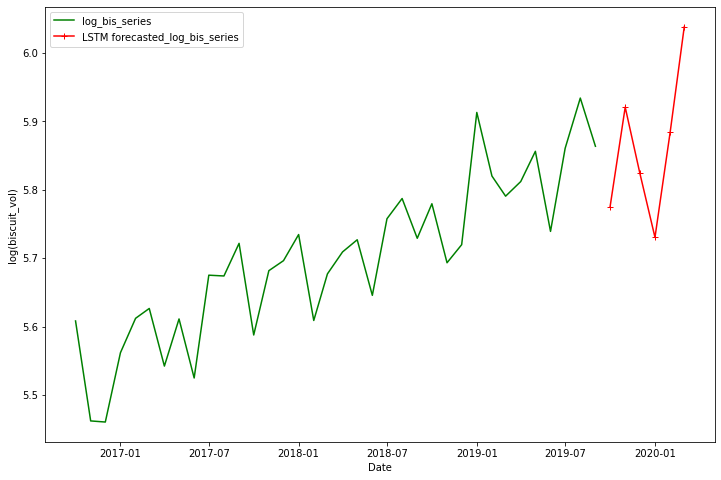

In [90]:
# Plotting the original & forecasted values of the log_bis series
# Displaying the True & Predicted values of the biscuit series
plt.figure(figsize=(12,8))
plt.plot(bis_log,color='green',label='log_bis_series')
plt.plot(forecast,color='red',marker='+',label='LSTM forecasted_log_bis_series')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('log(biscuit_vol)')
plt.show()

In [91]:
# Saving the finals LSTM model
Best_Model_lstm.save('Best_model_LSTM_bis_final.h5')

### Conclusion:
### 1) The test set rmse of our tuned LSTM model = 0.0773858, which is much more than the baseline rmse of 0.0512311 (corresponding to best naive model) and hence our LSTM Neural Net  doesn't  seem to have any predictive power on this dataset.